In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import random
import gc
import os
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
        
path_data = "../input/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

plt.style.use("seaborn")
sns.set(font_scale=1)

myfavouritenumber = 0
seed = myfavouritenumber
random.seed(seed)

pd.set_option('max_rows', 9999)
pd.set_option('max_columns', 9999)

In [2]:
## Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
df_train = pd.read_csv(path_train)
df_train = reduce_mem_usage(df_train, use_float16=True)
df_train.head()

Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [4]:
building = pd.read_csv(path_building)
building = reduce_mem_usage(building, use_float16=True)
le = LabelEncoder()
building.primary_use = le.fit_transform(building.primary_use)
building.head()

Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


In [5]:
weather_train = pd.read_csv(path_weather_train)
weather_train = reduce_mem_usage(weather_train, use_float16=True)
weather_train.head()

Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [6]:
def extract_id_meter(df, building_id, meter):
    temp = df[df['building_id'] == building_id].copy()
    temp = temp[temp['meter'] == meter]
    return temp

In [7]:
def prep_weather_data(df, mode='train'):
    
    # relative Hummd  #####################################################################
    # https://soudan1.biglobe.ne.jp/qa5356721.html
    a_temp = df['air_temperature'].values
    d_temp = df['dew_temperature'].values

    def SaturatedWaterVaporPressure(values):
        return 6.11 * 10 ** (7.5 * values / (237.3 + values))

    a_temp = SaturatedWaterVaporPressure(a_temp)
    d_temp = SaturatedWaterVaporPressure(d_temp)

    df['relative_hummd'] = d_temp / a_temp * 100
    del a_temp, d_temp
    gc.collect()

    # Disconfort Index  #####################################################################
    # https://keisan.casio.jp/exec/system/1202883065

    def disconfort_index(row):
        T = row['air_temperature']
        RH = row['relative_hummd']
        return 0.81 * T + 0.01 * RH * (0.99 * T - 14.3) + 46.3

    df['DI'] = df.apply(disconfort_index, axis=1)

    # Apparent Temperature  #####################################################################
    # https://keisan.casio.jp/exec/system/1257417058

    def apparent_temperature(row):
        T = row['air_temperature']
        RH = row['relative_hummd']
        A = 1.76 + 1.4 * row['wind_speed'] ** 0.75
        return 37 - (37 - T) / (0.68 - 0.0014 * RH + 1/A) - 0.29 * T * (1 - RH / 100)

    df['AT'] = df.apply(apparent_temperature, axis=1)

    # WCI  #####################################################################
    # https://www.metsoc.jp/tenki/pdf/2010/2010_01_0057.pdf

    def WCI(row):
        T = row['air_temperature']
        U = row['wind_speed']
        return (33 - T) * (10.45 + 10 * U ** 0.5 - U)

    df['WCI'] = df.apply(WCI, axis=1)

    # Wind Direction  #####################################################################
    df.loc[df['wind_direction'] == 65535, 'wind_direction'] = np.nan
    df.loc[df['wind_direction'] == 360, 'wind_direction'] = 0
    df['wind_direction'] = np.radians(df['wind_direction'])
    df['wind_direction_sin'] = np.sin(df['wind_direction'])
    df['wind_direction_cos'] = np.cos(df['wind_direction'])

    df['wind_speed_sin'] = df['wind_speed'] * df['wind_direction_sin']
    df['wind_speed_cos'] = df['wind_speed'] * df['wind_direction_cos']

    for c in ['wind_speed_sin', 'wind_speed_cos']:
        df[c] = df[c].astype(np.float16)

    # beaufort_scale  #####################################################################
    beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9),
                (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

    for item in beaufort:
        df.loc[(df['wind_speed'] >= item[1]) & (df['wind_speed'] < item[2]), 'beaufort_scale'] = item[0]

    # Create Features per Site Id  #####################################################################
    for i in range(df['site_id'].nunique()):
        temp = df[df['site_id'] == i]
        temp = temp.sort_values(by='timestamp')
        # Rolling
        cols = ['relative_hummd', 'DI', 'AT']
        for c in cols:
            for window in [24, 48]:
                # Mean
                colname = '{}_roll_{}_mean'.format(c, window)
                temp[colname] = temp[c].rolling(window).mean()
                df.loc[temp.index, colname] = temp.loc[temp.index, colname]
                df[colname] = df[colname].astype(np.float16)
                # Max
                colname = '{}_roll_{}_max'.format(c, window)
                temp[colname] = temp[c].rolling(window).max()
                df.loc[temp.index, colname] = temp.loc[temp.index, colname]
                df[colname] = df[colname].astype(np.float16)
                # Min
                colname = '{}_roll_{}_min'.format(c, window)
                temp[colname] = temp[c].rolling(window).min()
                df.loc[temp.index, colname] = temp.loc[temp.index, colname]
                df[colname] = df[colname].astype(np.float16)

        # Shift
        cols = ['relative_hummd', 'DI', 'AT']
        for c in cols:
            for period in [24, 48]:
                colname = '{}_shift_{}'.format(c, period)
                shifted = temp[c].shift(periods=period)
                temp[colname] = temp[c] - shifted
                df.loc[temp.index, colname] = temp.loc[temp.index, colname]
                df[colname] = df[colname].astype(np.float16)

        del temp
        gc.collect()

    return df


In [8]:
%%time
weather_train = prep_weather_data(weather_train)

Wall time: 36.6 s


In [9]:
def prepare_data(X, building_data, weather_data, test=False, sampling=None):
    """
    Preparing final dataset with all features.
    """
    
    X = X.merge(building_data, on="building_id", how="left")
    X = X.merge(weather_data, on=["site_id", "timestamp"], how="left")
    
    # Sampling
    if sampling is not None:
        X = X.sample(frac=sampling, random_state=42)
    
    X.timestamp = pd.to_datetime(X.timestamp, format="%Y-%m-%d %H:%M:%S")
    X.square_feet = np.log1p(X.square_feet)
    
    if not test:
        # Data Cleaning
        X['M'] = X['timestamp'].dt.month
        X['D'] = X['timestamp'].dt.day
        X = X.query('not (building_id <= 104 & meter == 0 & M <= 4)')
        X = X.query('not (building_id <= 104 & meter == 0 & M == 5 & D <= 20)')
        del X['M'], X['D']
        
        X.sort_values("timestamp", inplace=True)
        X.reset_index(drop=True, inplace=True)
    
    gc.collect()
    
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    
    drop_features = ["timestamp", "sea_level_pressure", "wind_direction", "wind_speed"]

    X.drop(drop_features, axis=1, inplace=True)
    
    # Set dtypes
    categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday"]
    for c in categorical_features:
        X[c] = X[c].astype('category')

    if test:
        row_ids = X.row_id
        X.drop("row_id", axis=1, inplace=True)
        return X, row_ids
    else:
        y = np.log1p(X.meter_reading)
        X.drop("meter_reading", axis=1, inplace=True)
        return X, y

In [10]:
X, y = prepare_data(df_train, building, weather_train, sampling=0.01)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val)

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.02,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

model = lgb.train(params, train_set=train_data, num_boost_round=1000, valid_sets=[train_data, valid_data], verbose_eval=200, early_stopping_rounds=200)

importance_df = pd.DataFrame()
importance_df["feature"] = X.columns.values
importance_df["importance"] = model.feature_importance()
importance_df.sort_values(by='importance', ascending=False, inplace=True)

d:\python\kaggle\ashrae~1\venv~1\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\python\kaggle\ashrae~1\venv~1\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\python\kaggle\ashrae~1\venv~1\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Training until validation scores don't improve for 200 rounds
[200]	training's rmse: 1.06113	valid_1's rmse: 1.12213
[400]	training's rmse: 0.934817	valid_1's rmse: 1.02251
[600]	training's rmse: 0.876391	valid_1's rmse: 0.988878
[800]	training's rmse: 0.838466	valid_1's rmse: 0.973775
[1000]	training's rmse: 0.80963	valid_1's rmse: 0.966401
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.80963	valid_1's rmse: 0.966401


In [11]:
importance_df

,feature,importance
0,building_id,13583
1,meter,4005
44,hour,2254
4,square_feet,1572
2,site_id,898
27,DI_roll_24_max,621
25,relative_hummd_roll_48_min,568
29,DI_roll_48_mean,557
36,AT_roll_48_max,553
31,DI_roll_48_min,549


In [12]:
del X, y, X_train, X_val, y_train, y_val, train_data, valid_data, model
gc.collect()

154

In [13]:
importance_df.to_csv('importance_pre.csv', index=False)

Half_Half_LightGBM Training

In [14]:
X_train, y_train = prepare_data(df_train, building, weather_train)

for c in X_train.select_dtypes(np.float64).columns.tolist():
    X_train[c] = X_train[c].astype(np.float32)
gc.collect()

del df_train, weather_train
gc.collect()

d:\python\kaggle\ashrae~1\venv~1\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\python\kaggle\ashrae~1\venv~1\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
d:\python\kaggle\ashrae~1\venv~1\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

0

In [15]:
# feature_num = 30

# features = importance_df['feature'][:feature_num].tolist()
# X_train = X_train[features]
# print(features)

X_half_1 = X_train[:int(X_train.shape[0] / 2)]
X_half_2 = X_train[int(X_train.shape[0] / 2):]

y_half_1 = y_train[:int(X_train.shape[0] / 2)]
y_half_2 = y_train[int(X_train.shape[0] / 2):]

d_half_1 = lgb.Dataset(X_half_1, label=y_half_1)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2)

watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.02,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

num_boost_round = 10000
early_stopping_rounds = 500

print("Building model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=num_boost_round, 
                         valid_sets=watchlist_1, verbose_eval=200, early_stopping_rounds=early_stopping_rounds)

print("Building model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=num_boost_round, 
                         valid_sets=watchlist_2, verbose_eval=200, early_stopping_rounds=early_stopping_rounds)

Building model with first half and validating on second half:
Training until validation scores don't improve for 500 rounds
[200]	training's rmse: 0.996251	valid_1's rmse: 1.22761
[400]	training's rmse: 0.864483	valid_1's rmse: 1.18814
[600]	training's rmse: 0.815686	valid_1's rmse: 1.17587
[800]	training's rmse: 0.790285	valid_1's rmse: 1.17318
[1000]	training's rmse: 0.771465	valid_1's rmse: 1.17145
[1200]	training's rmse: 0.759581	valid_1's rmse: 1.1707
[1400]	training's rmse: 0.748555	valid_1's rmse: 1.17026
[1600]	training's rmse: 0.739451	valid_1's rmse: 1.17011
[1800]	training's rmse: 0.729493	valid_1's rmse: 1.1705
[2000]	training's rmse: 0.720836	valid_1's rmse: 1.17004
Early stopping, best iteration is:
[1531]	training's rmse: 0.742284	valid_1's rmse: 1.16972
Building model with second half and validating on first half:
Training until validation scores don't improve for 500 rounds
[200]	training's rmse: 1.03378	valid_1's rmse: 1.22796
[400]	training's rmse: 0.879147	valid_1's

** Feature Importance **

Plotting the feature importance from LGBM.

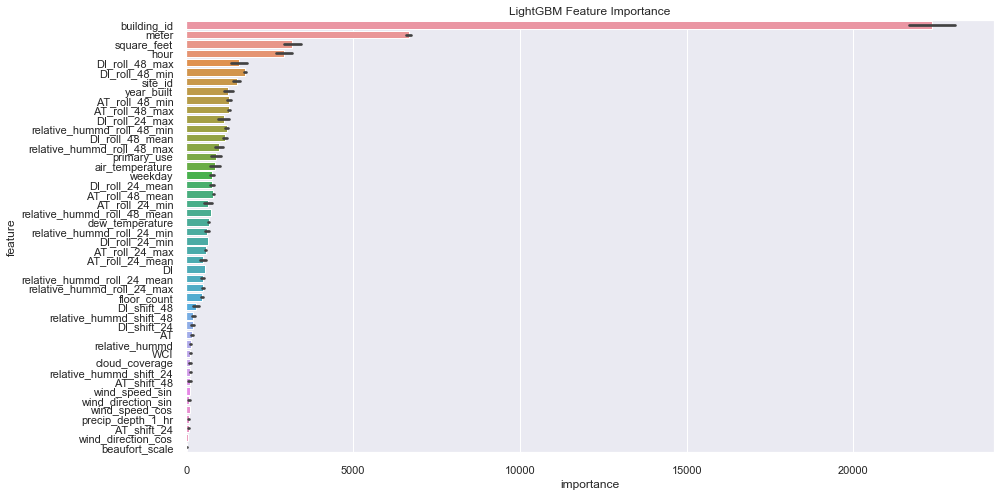

In [16]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_train.columns.values
df_fimp_1["importance"] = model_half_1.feature_importance()
df_fimp_1["half"] = 1

df_fimp_2 = pd.DataFrame()
df_fimp_2["feature"] = X_train.columns.values
df_fimp_2["importance"] = model_half_2.feature_importance()
df_fimp_2["half"] = 2

df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

plt.figure(figsize=(14, 14))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [17]:
del df_fimp_1, df_fimp_2, X_train, y_train
gc.collect()

10648

Preparing test data 

Preparing test data with same features as train data.

In [18]:
df_test = pd.read_csv(path_test)
weather_test = pd.read_csv(path_weather_test)

df_test = reduce_mem_usage(df_test, use_float16=True)
weather_test = reduce_mem_usage(weather_test, use_float16=True)
weather_test = prep_weather_data(weather_test)

X_test, row_ids = prepare_data(df_test, building, weather_test, test=True)

for c in X_test.select_dtypes(np.float64).columns.tolist():
    X_test[c] = X_test[c].astype(np.float32)
gc.collect()

Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 358.65 MB
Decreased by 71.8%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 5.25 MB
Decreased by 72.4%


56

In [19]:
pred = np.expm1(model_half_1.predict(X_test, num_iteration=model_half_1.best_iteration)) / 2

del model_half_1
gc.collect()

pred += np.expm1(model_half_2.predict(X_test, num_iteration=model_half_2.best_iteration)) / 2
    
del model_half_2
gc.collect()

12

In [20]:
today = datetime.datetime.now().strftime('%Y%m%d')
submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv(f"../Output/submission_from_nb_{today}.csv", index=False)
print("DONE")

DONE
